In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from networkx.algorithms import bipartite
import pandas as pd

In [70]:
def degree(g, nodes=None, as_list=True):
    deg = None
    if nodes:
        deg = dict(g.degree(nodes))
    else:
        deg = dict(g.degree())
    
    if as_list:
        return list(deg.values())
    return deg

def degree_plot(g, nodes, title=''):
    deg = degree(g, nodes)
    bins = 100
    if len(nodes) < 100:
        bins = len(nodes)
    hist = np.histogram(deg, bins=bins)
    v = range(min(deg), max(deg)+1)
    freqs, edges = hist[0], hist[1]
    n = freqs.size
    means = [(edges[i] + edges[i+1]) / 2 for i in range(n)]
    
    # SCATTER PLOT
    plt.plot(means, freqs, ".")
    plt.xlabel("k")
    plt.ylabel("frequency")
    plt.title("Degree distribution for %s" % title)
    plt.show()
    
    # LOG LOG PLOT
    plt.loglog(means, freqs, ".")
    plt.xlabel("log(k)")
    plt.ylabel("log(frequency)")
    plt.title("Log-log degree distribution for %s" % title)
    plt.show()

In [2]:
USER = 'user'
BIZ = 'biz'

In [3]:
df_biz = pd.read_csv('cleaned_csv/restaurants.csv')

In [4]:
df = pd.read_csv('csv_by_year/2017.csv')
df = df.drop('Unnamed: 0', axis=1)
df.head()

,business_id,date,review_id,stars,user_id
0,f5O7v_X_jCg2itqacRfxhg,2017-10-12,kS4hrhEScwB9V5JATYjvVQ,5,hxqo4NyJFfeOmuoVi--s1A
1,0bjFYstj8USMzEV4ZQldjA,2017-01-19,VKGvSe0SmYcFc5PqjbxLDQ,5,eG6HneK9zLcuZpVuKcsCGQ
2,gZGsReG0VeX4uKViHTB9EQ,2017-08-16,51RHs_V_fjuistnuKxNpEg,5,5ngpW5tf3ep680eG1HxHzA
3,-bd4BQcl1ekgo7avaFngIw,2017-06-28,P7kiSTiwzqm0_LbA71EOPg,5,5ngpW5tf3ep680eG1HxHzA
4,u73j2VQ3TGWdMO-AG7MABw,2017-07-06,7EgEjUpcb8q-B5dPCMvkaQ,2,5ngpW5tf3ep680eG1HxHzA


In [48]:
cities = set(df_biz.city.str.lower())
df_biz['city'] = df_biz.city.str.lower()
city_counts = dict(df_biz.groupby('city').city.count())
most_popular_city = max(city_counts.keys(), key=lambda k: city_counts[k])
most_popular_city, city_counts[most_popular_city]

('toronto', 9678)

In [94]:
df_toronto = df_biz[df_biz.city == most_popular_city]
biz_toronto = list(df_toronto.business_id)
rev_toronto = df[df.business_id.isin(df_toronto.business_id)]
print('Reviews:', len(rev_toronto))
print('Users:', len(set(rev_toronto.business_id)))
print('Businesses:', len(set(rev_toronto.user_id)))

Reviews: 71381
Users: 6174
Businesses: 25411


In [77]:
# A politcian class for storing data in a neat way.
class Node:
    def __init__(self, ID, Type):
        self.ID = ID
        self.Type = Type
    
    def to_string(self):
        return "Node (%s), ID: " % (self.Type, self.ID)
    
    def __hash__(self):
        return hash(self.ID)
    def __eq__(self, other):
        return (
                self.__class__ == other.__class__ and 
                self.ID == other.ID
               )

In [269]:
df_biz.postal_code = df_biz.postal_code.str.lower()
df_biz.postal_code = df_biz.postal_code.str.replace(' ', '_')

df_toronto.postal_code = df_toronto.postal_code.str.lower()
df_toronto.postal_code = df_toronto.postal_code.str.replace(' ', '_')

/Users/tnni/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [171]:
df_biz[df_biz.business_id == 'f5O7v_X_jCg2itqacRfxhg'].postal_code.iloc[0]

'm5g_1z8'

In [271]:
DF = rev_toronto.merge(df_toronto, on='business_id')

In [180]:
len(DF)

71381

In [181]:
len(rev_toronto)

71381

In [182]:
len(df_toronto)

9678

In [238]:
graph = nx.Graph()
for row in DF.itertuples():
    p = row.postal_code
    b = Node(p, BIZ)
    u = Node(row.user_id, USER)
    graph.add_edge(u, b)

In [239]:
print('Nodes:', len(graph.nodes()))
print('Edges:', len(graph.edges()))

Nodes: 28271
Edges: 69721


In [240]:
biz_nodes = [n for n in list(graph.nodes()) if n.Type == BIZ]
user_nodes = [n for n in list(graph.nodes()) if n.Type == USER]

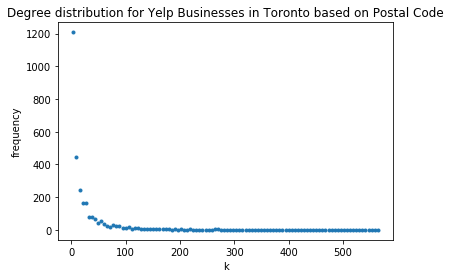

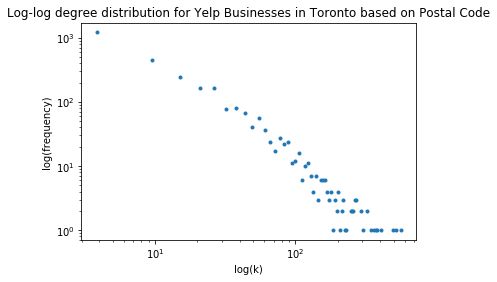

In [241]:
degree_plot(graph, biz_nodes, "Yelp Businesses in Toronto based on Postal Code")

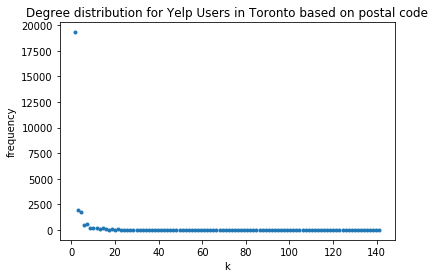

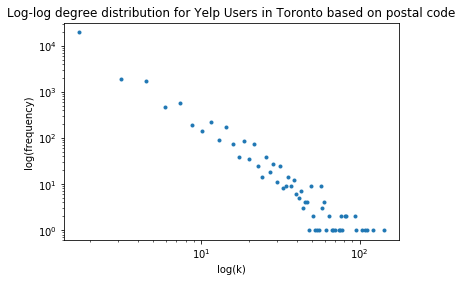

In [242]:
degree_plot(graph, user_nodes, "Yelp Users in Toronto based on postal code")

In [243]:
ev_centrality = nx.eigenvector_centrality_numpy(graph)

In [244]:
sorted_ev_centrality = sorted(ev_centrality.items(), key=lambda x: x[1], reverse=True)

In [245]:
ev_biz = [(n, ev) for (n, ev) in sorted_ev_centrality if n.Type == BIZ]
ev_user = [(n, ev) for (n, ev) in sorted_ev_centrality if n.Type == USER]

In [246]:
ev_biz[:5]

[(<__main__.Node at 0xa2cbf37f0>, 0.1857423445489796),
 (<__main__.Node at 0xa2ccd2c18>, 0.14640756065255306),
 (<__main__.Node at 0xa1c0bddd8>, 0.1343926261733672),
 (<__main__.Node at 0xa2cef69e8>, 0.12868586326905768),
 (<__main__.Node at 0xa2cd123c8>, 0.11749122183150403)]

In [247]:
ev_user[:5]

[(<__main__.Node at 0xde955d438>, 0.08235545357020468),
 (<__main__.Node at 0xa29b2a898>, 0.07819692915338444),
 (<__main__.Node at 0xa21393c18>, 0.07653589042605748),
 (<__main__.Node at 0xa1ebb2390>, 0.07633188512697481),
 (<__main__.Node at 0xde9548d68>, 0.07525123940168754)]

In [248]:
ev_biz[0][0].ID

'm5t_1l1'

In [278]:
for i in range(20):
    postal_code = ev_biz[i][0].ID
    biz = df_toronto[df_toronto.postal_code == postal_code]
    print('Postal code:', postal_code)
    for n in list(biz.name):
        print('\t', n)

Postal code: m5t_1l1
	 ND Sushi & Grill
	 Gateway of India
	 Agave Y Aguacate
	 Wah Sing Seafood Restaurant
	 Vegetarian Haven
	 Mcramyun
	 Light Cafe
	 Hanoi Bistro
	 Kekou Gelato House
	 Matahari Grill
	 KINTON RAMEN
	 Sushi Tanoshii
	 Jodhpore Club Indian Restaurant
	 Sambuca Grill
	 Kowloon Dim Sum Restaurant
	 Eating Garden Chinese Restaurant
	 Fujiyama Japanese Restaurant
	 Mo' Ramyun
	 John's Italian Caffe
	 Kappo Sushi
	 Bicerin Espresso Bar
	 Reforma
	 Omai Restaurant
	 Arctic Bites
	 Hana Korea Restaurant
	 Valens Restaurant
	 Charidise
	 7 Dim Sum
	 Platito Filipino Soul Food
	 Panpan Noodle Bar
	 Mala Express Restaurant
Postal code: m5h_3g8
	 Pai Northern Thai Kitchen
	 Grace O'Malley's
Postal code: m5g_1c3
	 Big Fat Burrito
	 Bapbo Korean Restaurant
	 Butter Baker
	 First Choice Restaurant
	 Shish Kabab Express
	 Green Onion Pan Asian Cuisine
	 Mac's Convenience Stores
	 DonDon Izakaya
	 Kenzo Ramen
	 Chatime - Dundas
	 Pablo Cheesetart Canada
	 Thai One On
	 Alio Restaura

## Plotting the subgraph

In [250]:
top_reviews = DF.groupby("user_id").filter(lambda x: len(x) > 5)
top_reviews = top_reviews.groupby("postal_code").filter(lambda x: len(x) > 50)
print('Reviews:', len(top_reviews))
print('Users:', len(set(top_reviews.user_id)))
print('Businesses:', len(set(top_reviews.business_id)))

Reviews: 13751
Users: 2354
Businesses: 900


In [251]:
sub_graph = nx.Graph()
for row in top_reviews.itertuples():
    b = Node(row.business_id, BIZ)
    u = Node(row.user_id, USER)
    sub_graph.add_edge(u, b)

In [252]:
from fa2l import force_atlas2_layout

In [253]:
nodes = sub_graph.nodes()
degrees = 5 * np.array(degree(sub_graph))
color_map = []
for p in nodes:
    if p.Type == USER: 
        color_map.append("red")
    elif p.Type == BIZ: 
        color_map.append("blue")
    else: 
        color_map.append("#black")

In [216]:
positions = force_atlas2_layout(sub_graph,
                                iterations=3,
                                pos_list=None,
                                node_masses=None,
                                outbound_attraction_distribution=False,
                                lin_log_mode=False,
                                prevent_overlapping=False,
                                edge_weight_influence=1.0,

                                jitter_tolerance=1.0,
                                barnes_hut_optimize=False,
                                barnes_hut_theta=0.5,

                                scaling_ratio=2.0,
                                strong_gravity_mode=False,
                                multithread=False,
                                gravity=1.0)

/Users/tnni/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/Users/tnni/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:


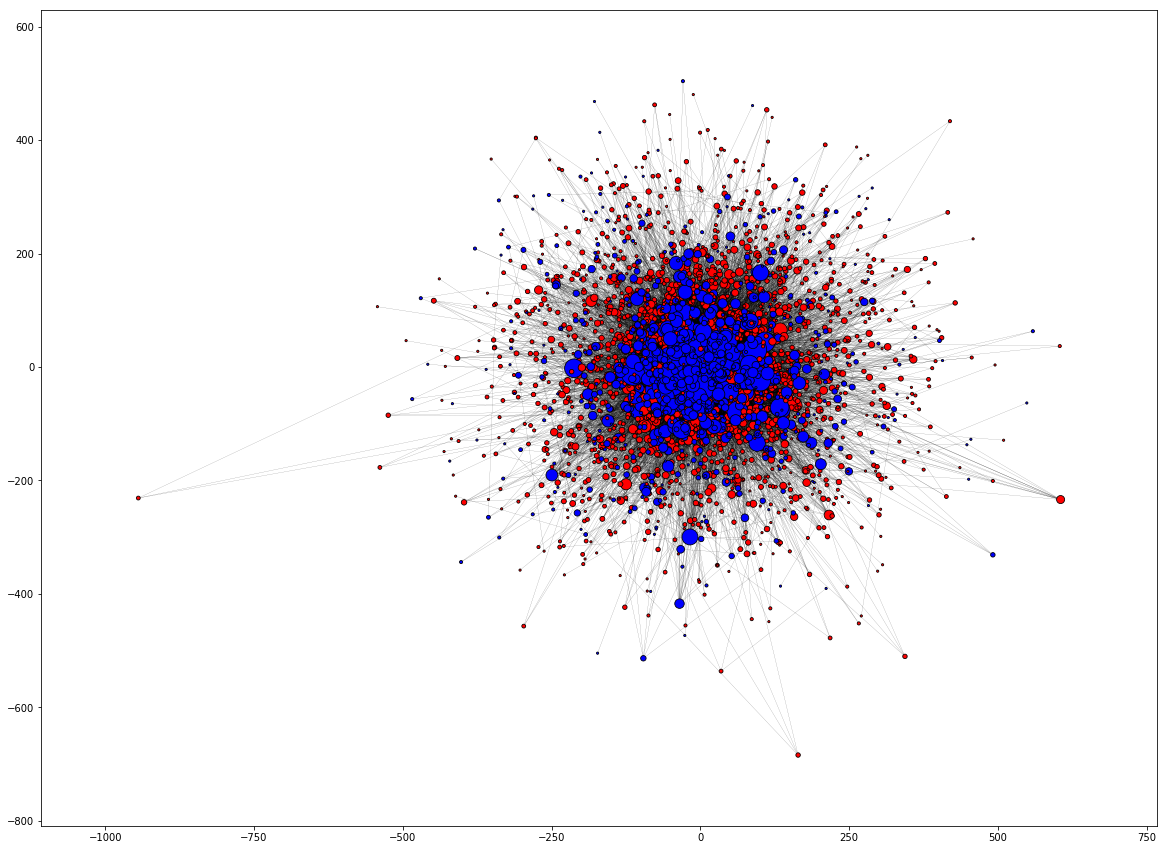

In [217]:
plt.figure(figsize=[20,15])
nx.draw_networkx(sub_graph, positions, with_labels=False, node_color=color_map, node_size=degrees, width=0.1, linewidths=0.8)
plt.gca().collections[0].set_edgecolor("#000000") 
plt.show()

In [154]:
B_deg = degree(B, as_list=False)

In [155]:
sort_degree = sorted(deg_biz.items(), key=lambda x: x[1], reverse=True)